In [3]:
%pip install pykrige
%pip install xarray==2024.05.0

  Using cached PyKrige-1.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached PyKrige-1.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (979 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached xarray-2024.5.0-py3-none-any.whl.metadata (11 kB)
Using cached xarray-2024.5.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.4.0
    Uninstalling xarray-2025.4.0:
      Successfully uninstalled xarray-2025.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xmip 0.7.2 requires cf_xarray>=0.6.0, which is not installed.
xmip 0.7.2 requires xarrayutils, which is not installed.
xmip 0.7.2 requires xgcm<0.7.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [13]:
%matplotlib widget

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from skimage import exposure
from skimage.io import imsave, imread
from osgeo import ogr
import pystac_client
from pyproj import Transformer
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import geopandas as gpd
import pandas as pd
import geoviews as gv
import hvplot.pandas
import intake
import xarray as xr
import numpy as np
from numpy.random import default_rng
import intake
from pyproj import Proj, transform
from osgeo import gdal
from sklearn.neighbors import BallTree
import earthaccess
import gzip

# for progress bar
from ipywidgets import IntProgress
from IPython.display import display
from ipywidgets import interact, Dropdown
import time
from tqdm.notebook import trange, tqdm

import boto3
import rasterio as rio
from rasterio.features import rasterize
from rasterio.session import AWSSession
import dask
import os
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.warp import Resampling as resample
import cartopy.crs as ccrs
import cartopy
from pykrige.ok import OrdinaryKriging
from sklearn.linear_model import LinearRegression, RANSACRegressor
from scipy.odr import Model, RealData, ODR
import scipy.odr as odr
import scipy
import statsmodels.formula.api as smf
from shapely.geometry.polygon import Polygon, Point
import pygmt
import gc
import pytz
import pyproj
import math
from pathlib import Path
from matplotlib.patches import Polygon as Pgon
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

import SSTutils as stu

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Coefficients for calibration
calib_m = 0.76 
calib_b = 0.55

# Run SST algorithm

## Read in all paths and parameters

In [15]:
timing = time.time()

In [16]:
# Define the landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'

# For atm correction
basepath = Path('/home/jovyan/Landsat_SST_algorithm')
lsatpath = basepath / 'Data'
atmpath = lsatpath / 'AtmCorrection'
modout_path = lsatpath / 'MOD07_L2'

WV = 'Water_Vapor'

# For search and tile plot for Landsat
satellite = 'Landsat8'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1 - includes L8 and L9
colnm = ['landsat:wrs_path','landsat:wrs_row']
gjson_outfile = lsatpath / f'{satellite}.geojson'

# # For scene search and plot

interp = 1

region = 'Cosgrove'

if region=='Cosgrove':
    SSTpath = lsatpath / 'SST/MODcalib/Cosgrove/'
    bbox = (-103.0, -73.5, -102.0, -73.42) # LatboundsC from LandsatCalibration20201031
    # Cosgrove full run 
    timeRange = '2021-09-01/2023-04-07'
    # [0:1] Cosgrove bbox
    # timeRange = '2022-11-01/2023-03-27'
elif region=='DotsonPolynya':
    SSTpath = lsatpath / 'SST/MODcalib/DotsonPolynya/'
    bbox = (-113, -73.9, -111.5, -73.59) # Dotson polynya
    # Dotson full run
    timeRange = '2021-09-01/2023-05-31'
    # [0:1] Dotson bbox
    # timeRange = '2022-11-01/2023-03-27'
elif region=='PineIslandPlume':
    SSTpath = lsatpath / 'SST/UncalibratedSST/PineIslandPlume/'
    bbox = (-101.98,-75.09,-101.65,-75.05) # PIG plume for analysis - 2014
    # bbox = (-101.88,-75.23,-100.35,-74.76) # PIG ice front for analysis
    # bbox = (-101.8,-75.23,-100.50,-74.80) # PIG 2019?
    # PIG full run - NOT narrowed down yet
    timeRange = '2021-09-01/2023-04-07'
elif region=='DotsonIntercomp':
    SSTpath = lsatpath / 'SST/Validation/DotsonIntercomp/'
    bbox = (-113.5,-74.20,-113.17,-74.11) # Dotson plume for analysis
    # Dotson intercomp run
    timeRange = '2021-09-01/2023-03-31'
elif region=='Burke':
    SSTpath = lsatpath / 'SST/MODcalib/Burke/'
    bbox = (-104.2,-73.81, -103.8, -73.42) # Outside Cosgrove south of Burke  
    # Burke full run
    timeRange = '2021-09-01/2023-04-06'
    
# bbox = (-99.2,-69.9,-98.4, -69.6) # Offshelf BAD

# # Interpolation test values, keep scene [2:3]
# bbox = (-106.5, -75.0, -104.9, -74.7) #(west, south, east, north) 
# timeRange = '2019-02-06/2019-02-07'

# timeRange = '2023-03-30/2023-03-31'
# timeRange = '2022-12-18/2022-12-19'
# timeRange = '2023-02-05/2023-02-06'
# timeRange = '2013-01-05/2025-02-06'

## Authenticate for accessing all data

In [17]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [18]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/41951/status,
Dashboard: /user/tsnow03/proxy/41951/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36053,Workers: 4
Dashboard: /user/tsnow03/proxy/41951/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:36145,Total threads: 1
Dashboard: /user/tsnow03/proxy/33947/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:45819,


Task exception was never retrieved
future: <Task finished name='Task-269956' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-269870' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-269979' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/li

In [19]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # Ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

## Derive SST monthly retrieval coefficients

Landsat 8 single-channel SST algorithm:

$$
  SST = a_0 + a_1\,T_L + a_2\,WV\,T_L
$$

where $a_k$ are derived coefficients, $T_L$ is TOA brightness temperature, and $WV$ is total column water vapor. We use this in `apply_retrieval`.

**Add TOA equations**

To calculate $WV$ ([https://resources.eumetrain.org/data/3/359/navmenu.php?tab=2&page=1.0.0](https://resources.eumetrain.org/data/3/359/navmenu.php?tab=2&page=1.0.0)) from ERA-5 specific humidities at atmospheric pressure levels along the total atmospheric column we use:

$$
  WV = \frac{1}{\rho_w\,g} \int_{p_z}^0 q*100\,dp
$$

where $p_w$ is the water density 1000 $kg/m^3$; $g$ is the gravitational constant 9.8 $m/s^2$; $q$ is the specific humidity (kg/kg) of water vapor in hPa at pressure level $p$, and $p_s$ is surface air pressure in hPa. That is calulated in `spec_hu_to_tcwv`. These equations result in $WV$ with units $kg/m^2$ equivalent to mm. MODIS TCWV has units of cm so we then divide $WV$ by 10 to match MODIS. 

01: 1175
02: 1417
03: 1417
04: 1145
05: 958
06: 605
07: 515
08: 712
09: 327
10: 315
11: 314
12: 772
ERA5 count: 9672
Simulated TOA min: 270.17, and max: 275.18
Simulated WV min: 0.037, and max: 2.0716
Simulated SST min: 270.17, and max: 275.18


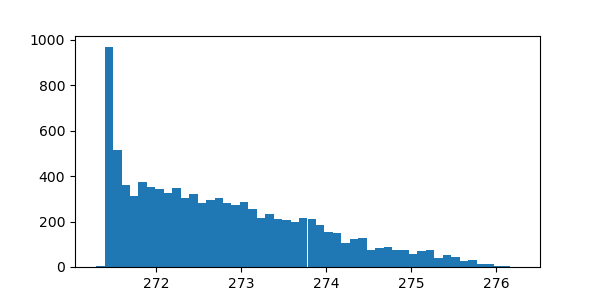

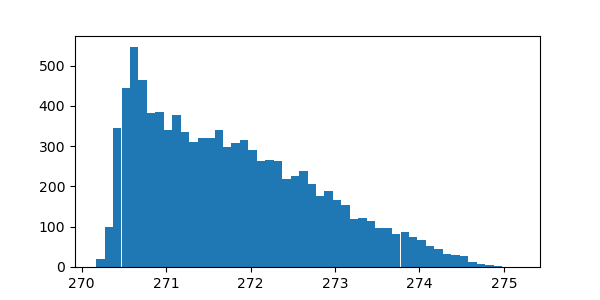

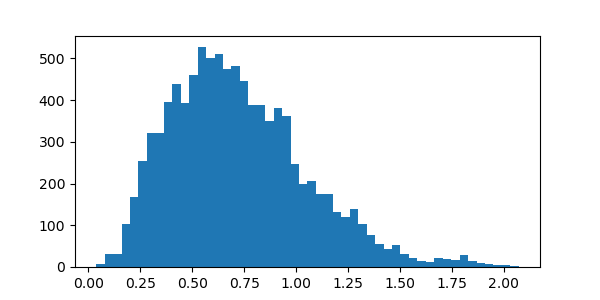

In [20]:
# # Create scalar for normalizing T, TOA, and WV data
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

modtran_lut,n = stu.concat_modtran_months(months,atmpath)

simTOA = modtran_lut[['TOA T[K]']]
simWV = modtran_lut[['TCWV [cm]']]
# simT = modtran_lut[['Surface T[K]']] # Decided this was skewed because of Andy's forcings so use TOA scaler instead
simT = simTOA.rename(columns={'TOA T[K]': 'Surface T[K]'})

print(f'ERA5 count: {n}')
print(f'Simulated TOA min: {np.around(simTOA.min().values[0],2)}, and max: {np.around(simTOA.max().values[0],2)}')
print(f'Simulated WV min: {np.around(simWV.min().values[0],4)}, and max: {np.around(simWV.max().values[0],5)}')
print(f'Simulated SST min: {np.around(simT.min().values[0],2)}, and max: {np.around(simT.max().values[0],2)}')

simTOA_transformer = StandardScaler().fit(simTOA)
simWV_transformer = StandardScaler().fit(simWV)
# simT_transformer = RobustScaler().fit(simT)
simT_transformer = StandardScaler().fit(simT) # This is using TOA at the moment until get updated TOA


plt.figure(figsize=(6, 3))
plt.hist(modtran_lut['Surface T[K]'], bins=50);

plt.figure(figsize=(6, 3))
plt.hist(modtran_lut['TOA T[K]'], bins=50);

plt.figure(figsize=(6, 3))
plt.hist(modtran_lut['TCWV [cm]'], bins=50);

In [21]:
# Derive coefficients for SST retrievals
atmcor,retrieval_results,modtran_lut_norm = stu.derive_coeffs(atmpath,simTOA_transformer,simWV_transformer,simT_transformer)

Processing rolling window for middle month 01
12: 772
01: 1175
02: 1417
Rolling for month 01: toa = 1.08, tcwv_toa = -0.02, Intercept = 0.96, R2 = 0.98
p-values for month 01: toa = 0.0, tcwv_toa = 0.0, Intercept = 0.0
Processing rolling window for middle month 02
01: 1175
02: 1417
03: 1417
Rolling for month 02: toa = 1.08, tcwv_toa = -0.01, Intercept = 0.96, R2 = 0.98
p-values for month 02: toa = 0.0, tcwv_toa = 0.011, Intercept = 0.0
Processing rolling window for middle month 03
02: 1417
03: 1417
04: 1145
Rolling for month 03: toa = 1.07, tcwv_toa = 0.01, Intercept = 0.99, R2 = 0.99
p-values for month 03: toa = 0.0, tcwv_toa = 0.007, Intercept = 0.0
Processing rolling window for middle month 04
03: 1417
04: 1145
05: 958
Rolling for month 04: toa = 1.06, tcwv_toa = 0.01, Intercept = 0.99, R2 = 0.98
p-values for month 04: toa = 0.0, tcwv_toa = 0.0, Intercept = 0.0
Processing rolling window for middle month 05
04: 1145
05: 958
06: 605
Rolling for month 05: toa = 1.05, tcwv_toa = -0.0, In

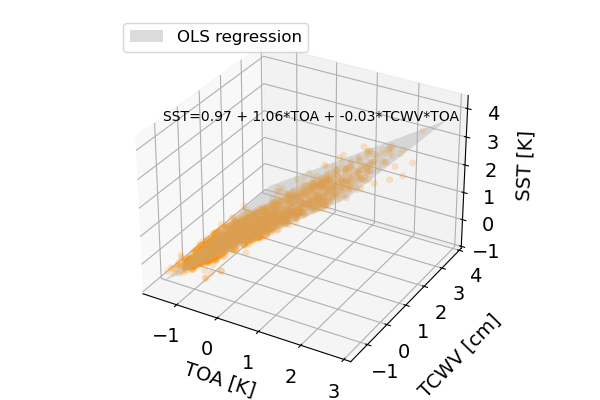

In [22]:
# Plot multiple linear regression in 3D for December as an example
data = modtran_lut_norm

a1 = atmcor['12']['a1']
a2 = atmcor['12']['a2']
a3 = atmcor['12']['a3']

# Generating predictions for a range of TOA and TCWV values
xi = np.linspace(data['TOA T[K]'].min(), data['TOA T[K]'].max(), 100)
wi = np.linspace(data['TCWV [cm]'].min(), data['TCWV [cm]'].max(), 100)
X, W = np.meshgrid(xi, wi)
Z_pred = retrieval_results.predict(exog=dict(toa=X.ravel(), tcwv_toa=(X*W).ravel())).values.reshape(X.shape)

# Create a figure and a 3D axes
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

ax.tick_params(labelsize=14)
ax.plot_surface(X,W,Z_pred,color='0.8', alpha=0.5,label='OLS regression',zorder=0)
ax.scatter(data['TOA T[K]'],data['TCWV [cm]'],data['Surface T[K]'],color='darkorange',linewidth=0,s=25,alpha=0.2,label='_no label_',zorder=2)
ax.text(-2.8,1,3.0,f'SST={a3} + {a1}*TOA + {a2}*TCWV*TOA',fontsize=10)
# a1.set_ylim([-3,2.5])
# a1.set_xlim([-3,2.5])
ax.set_xlabel('TOA [K]',labelpad=6,fontsize=14)
ax.set_ylabel('TCWV [cm]',labelpad=13,fontsize=14)
ax.set_zlabel('SST [K]',labelpad=6,fontsize=14)
ax.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tashasnow/Library/CloudStorage/GoogleDrive-tsnow03@gmail.com/My\ Drive/GoogleDrivePhD_postdoc/PhD_Project/Manuscripts/LandsatManuscript/Figures/MODTRANretrieval.jpg', format='jpg', dpi=1000)
plt.show()

## Search for desired Landsat scenes

In [23]:
# Search for desired Landsat scenes
items = stu.search_stac(url, collection, gjson_outfile=gjson_outfile, bbox=bbox, timeRange=timeRange)

# Open stac catalog for some needed info
catalog = intake.open_stac_item_collection(items)

# Load the geojson file
gf = gpd.read_file(gjson_outfile)

Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


In [24]:
# Plot tiles of all scenes found
stu.plot_search(gf,satellite,colnm)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (landsat:wrs_path,landsat:wrs_row)

**Note the bands you would like to include are assigned by passing the bandNames parameter to landsat_to_xarray using the following codes:**

'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'pan', 'cirrus', 'lwir11', 'lwir12', 'qa_pixel'

## Process Landsat scenes to acquire sea surface temperature

In [25]:
# Convert bounding box to polar for checking if landsat has any data in bounding box
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

sbox,checkbox = stu.lsat_reproj(source_crs,target_crs,(bbox[0],bbox[1],bbox[2],bbox[3]))

# Create polygon for later cropping
polygon = Polygon([(sbox[0][0],sbox[0][1]),(sbox[3][0],sbox[3][1]),(sbox[2][0],sbox[2][1]),(sbox[1][0],sbox[1][1])])

# Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
minx, miny, maxx, maxy = polygon.bounds
polarx = [minx, maxx]
polary = [miny, maxy]

In [26]:
%%time
# ***Problems downloading w earthaccess (tried up one and up down one version) or xarray reading (tried up and down versions, but didn't try other engines like rasterio)
## 1 min 1 sec per image without interpolation, 1 min 5 s with interp, no extra memory 
## With all clusters - 4 min 20 sec @ 15k, 4 min 6 sec @ 10k, 6 min 40 sec @ 5k

# Saves MODIS water vapor file name in COG so know what each image was corrected with

# Include only Landsat 8 scenes
catalog_list = [x for x in items if x.id[3]=='8']

for sceneid in tqdm(catalog_list, desc="Processing"):
    print(sceneid.id)
    
    scene = catalog[sceneid.id]
    timestr = scene.metadata['datetime'].strftime('%H%M%S')

    outFile = f'{SSTpath}/{sceneid.id}_{timestr}_Cel.tif'
    
    if os.path.isfile(outFile):
        print (f'{sceneid.id} - atm corr exists')

    else:
        # Open all desired bands for one scene
        ls_scene = stu.landsat_to_xarray(sceneid,catalog)
        ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

        # Create classification mask
        ls_scene = stu.create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)
        
        try:
            # Check for any open ocean pixels in bounding box - go to next image if none - 9.3 s
            mask = np.ones(ls_scene.shape[1:])
            mask[ls_scene.mask!=3] = np.nan
            ls_thermal = ls_scene.sel(band='lwir11').compute()
            ls_box = stu.subset_img(ls_thermal*mask,polarx,polary)
    
            if ((ls_box).notnull()).sum().values==0:
                print (f'{sceneid.id} has no SSTs')
                try:
                    del ls_scene, scene, mask, ls_thermal, ls_box
                except:
                    pass
                gc.collect()
                continue
                
            # Use band ratios for RF cloud pixel classification
            # ###
    
            # Atmospheric correction using MODIS
            # Acquire and align MODIS water vapor (MOD/MYD07) to Landsat
            mod07,modfilenm = stu.open_MODIS(ls_scene,scene,modout_path)
    
            # Create water vapor files aligned and subsampled to Landsat
            spacing = [300,-300] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long, 1 must be negative for MODISlookup
    
            #***has not yet been tested to ensure no interp works properly
            WV_xr = stu.get_wv(ls_scene,mod07,spacing,WV,scene,interp=interp)
    
            # Create SST by masking and using water vapor to apply month-specific atmospheric correction
            SST = stu.apply_retrieval(ls_thermal,scene,mask,WV_xr,atmcor,simT_transformer,simTOA_transformer,simWV_transformer)
    
            # Record MODIS water vapor image used in atmospheric correction, will find this info save under band_data in
            # data variables in COG (click on white paper info button in xarray readout)
            SST.attrs['MODIS_WV'] = modfilenm
    
            print (f'Mean SST: {np.nanmean(SST)}')
    
            # Save to a cloud-optimized Geotiff
            SST.rio.to_raster(raster_path=outFile, driver="COG")
                
        except Exception as e:
            print (f'{sceneid.id} has no SSTs: {e}')
        
        try:
            del ls_scene, scene, ls_thermal, ls_box, mod07, WV_xr, SST
        except:
            pass
        
        gc.collect()

Processing:   0%|          | 0/178 [00:00<?, ?it/s]

LC08_L1GT_002112_20230406_20230412_02_T2
20 TOTAL granules
A granule has a problematic polygon that likely crosses the International DateLine
A granule has a problematic polygon that likely crosses the International DateLine
TopologyException: side location conflict at -75.891037882737649 -71.714827762325314. This can occur if the input geometry is invalid.
A granule has a problematic polygon that likely crosses the International DateLine
A granule has a problematic polygon that likely crosses the International DateLine
A granule has a problematic polygon that likely crosses the International DateLine
6 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:12:17


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 2204 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Mean water vapor value is: 0.2708086343573077, min: 0.2183, max: 0.3415
Mean SST: -7.926102920179451


Processing:   1%|          | 1/178 [02:43<8:02:57, 163.72s/it]

LC08_L1GT_004112_20230404_20230412_02_T2
25 TOTAL granules
A granule has a problematic polygon that likely crosses the International DateLine
TopologyException: side location conflict at -74.027667949454155 -74.977503132431906. This can occur if the input geometry is invalid.
A granule has a problematic polygon that likely crosses the International DateLine
A granule has a problematic polygon that likely crosses the International DateLine
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:30:19


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 3813 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Mean water vapor value is: 0.23425602535557216, min: 0.16919, max: 0.30502
Mean SST: -5.442079939467583


Processing:   1%|          | 2/178 [04:38<6:35:09, 134.71s/it]

LC08_L1GT_006112_20230402_20230412_02_T2
LC08_L1GT_006112_20230402_20230412_02_T2 has no SSTs


Processing:   2%|▏         | 3/178 [05:04<4:08:45, 85.29s/it] 

LC08_L1GT_001112_20230330_20230405_02_T2
LC08_L1GT_001112_20230330_20230405_02_T2 has no SSTs


Processing:   2%|▏         | 4/178 [05:33<3:02:13, 62.83s/it]

LC08_L1GT_003112_20230328_20230405_02_T2
LC08_L1GT_003112_20230328_20230405_02_T2 has no SSTs


Processing:   3%|▎         | 5/178 [06:06<2:31:01, 52.38s/it]

LC08_L1GT_005112_20230326_20230404_02_T2
21 TOTAL granules
A granule has a problematic polygon that likely crosses the International DateLine
TopologyException: side location conflict at -62.576462133719289 -73.575571665852877. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -88.73903998211091 -71.98034696924698. This can occur if the input geometry is invalid.
A granule has a problematic polygon that likely crosses the International DateLine
TopologyException: side location conflict at -57.446790541985706 -71.371390892171135. This can occur if the input geometry is invalid.
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:49:01


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 2648 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Mean water vapor value is: 0.4290853270462998, min: 0.26611, max: 0.6574
Mean SST: -7.000293720294996


Processing:   3%|▎         | 6/178 [07:58<3:27:42, 72.46s/it]

LC08_L1GT_002112_20230321_20230325_02_T2
LC08_L1GT_002112_20230321_20230325_02_T2 has no SSTs


Processing:   4%|▍         | 7/178 [08:26<2:45:31, 58.08s/it]

LC08_L1GT_004112_20230319_20230324_02_T2
22 TOTAL granules
A granule has a problematic polygon that likely crosses the International DateLine
TopologyException: side location conflict at -6.012348948727551 -74.298914252910038. This can occur if the input geometry is invalid.
A granule has a problematic polygon that likely crosses the International DateLine
TopologyException: side location conflict at -58.103775310008565 -72.444370181581462. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -25.610869156186073 -71.926506971709188. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -106.84284703379248 -66.581573264938996. This can occur if the input geometry is invalid.
4 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:00:07


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 3781 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


Mean water vapor value is: 0.38716637667578846, min: 0.23574, max: 0.64254
Mean SST: -7.179528054761014


Processing:   4%|▍         | 8/178 [09:52<3:09:07, 66.75s/it]

LC08_L1GT_006112_20230317_20230324_02_T2


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4258191050>>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2025-06-21 13:37:11,611 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-06-21 13:37:11,611 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-06-21 13:37:11,611 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
Traceback (most recent call last):
2025-06-21 13:37:11,615 - distributed.nanny - ERROR - Worker process died unexpectedly
  File "/srv/conda/envs/notebook/lib/python3.11/asyncio/runners.py", line 118, in run
    retu

## Check interpolation outcome [under construction]

In [ ]:
# Use the function with your directory path
stu.create_geotiff_dropdown(SSTpath)

In [21]:
wv2 = mask*WV_xr.values

# # Get rid of low outliers from over ice, cutoff for 98.5%
# outlier = np.quantile(wv2[np.isfinite(wv2)],0.01)
# mask2 = np.ones(wv2.shape)
# mask2[wv2<outlier] = np.nan

# wv3 = mask2*wv2
wv3 = np.around(wv2,decimals=5)

means = np.nanmean(wv3)
print (f'Mean water vapor value is: {means}, min: {np.nanmin(wv3)}, max: {np.nanmax(wv3)}')

# Select appropriate atmospheric correction coefficients
month = scene.metadata['datetime'].month
a_mo = f'{2}'.zfill(2)
a1 = atmcor[a_mo]['a1']
a2 = atmcor[a_mo]['a2']
a3 = atmcor[a_mo]['a3']


NameError: name 'WV_xr' is not defined

In [33]:
# Calculate radiances using MTL data
s3 = boto3.client("s3")

# Extract bucket and key for json MTL file
# Example: bucket = "usgs-landsat" ; key = "collection02/level-1/standard/oli-tirs/2019/002/113/LC08_L1GT_002113_20190206_20201016_02_T2/LC08_L1GT_002113_20190206_20201016_02_T2_MTL.json"
s3_url = scene['MTL.json'].metadata['alternate']['s3']['href']
bucket = s3_url.split('/')[2].strip()
key = s3_url.split(bucket)[1].strip()[1:]

# Get MLT data
res = s3.get_object(Bucket=bucket, Key=key, RequestPayer="requester")
MTL = res["Body"].read().decode("utf-8")

# Get important constants from MTL
ind = MTL.find('K1_CONSTANT_BAND_10')
K1_10 = float(MTL[ind+23:ind+31])
ind = MTL.find('K2_CONSTANT_BAND_10')
K2_10 = float(MTL[ind+23:ind+32])
ind = MTL.find('RADIANCE_MULT_BAND_10')
ML10 = float(MTL[ind+25:ind+35])
ind = MTL.find('RADIANCE_ADD_BAND_10')
AL10 = float(MTL[ind+24:ind+31])

# Mask no data 
DN_masked = ls_thermal.where(ls_thermal != 0)

# Top of Atmosphere radiance for Band 10
Llambda = ML10 * DN_masked + AL10

# Top of Atmosphere brightness temperature for Band 10
T10 = K2_10 / np.log((K1_10 / Llambda) + 1)

In [34]:
T10 = mask * T10
toa=T10
# SST = a3 + a1*toa + a2*wv3*toa - 273.15
# SST = SST.compute()

In [47]:
# Convert toa DataArray to numpy, preserving shape.
toa_arr = toa.values
original_toa_shape = toa_arr.shape
# Reshape to a column vector for the transformer
toa_norm = simTOA_transformer.transform(toa_arr.reshape(-1, 1))
toa_norm = toa_norm.reshape(original_toa_shape)

# Convert wv DataArray to numpy array and transform similarly.
original_wv_shape = wv3.shape
wv_norm = simWV_transformer.transform(wv3.reshape(-1, 1))
wv_norm = wv_norm.reshape(original_wv_shape)

# Calculate normalized SST using the retrieval coefficients and water vapor
SST_norm = a3 + a1 * toa_norm + a2 * wv_norm * toa_norm

# Inverse transform SST: again reshape as needed.
original_sst_shape = SST_norm.shape
SST_norm_flat = SST_norm.reshape(-1, 1)
SST_flat = simT_transformer.inverse_transform(SST_norm_flat)
SST = SST_flat.reshape(original_sst_shape) - 273.15

# Optionally, convert the result back into an xarray.DataArray,
# preserving the original toa coordinates and dimensions:
SST = xr.DataArray(SST, coords=toa.coords, dims=toa.dims)

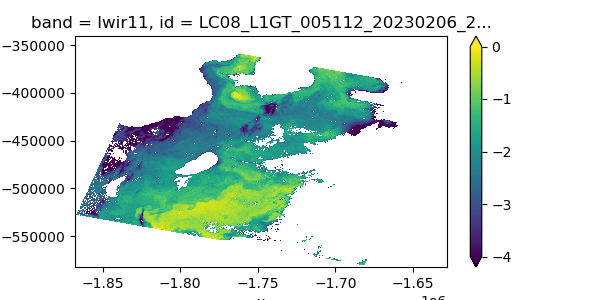

In [51]:
# January atm correction
plt.figure(figsize=(6, 3))
(SST).plot.imshow(x='x',y='y',vmin=-4,vmax=0)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([11223.        , 11977.09960938, 12731.20019531, 13485.29980469,
        14239.40039062, 14993.5       , 15747.59960938, 16501.69921875,
        17255.80078125, 18009.90039062, 18764.        ]),
 <a list of 7991 BarContainer objects>)

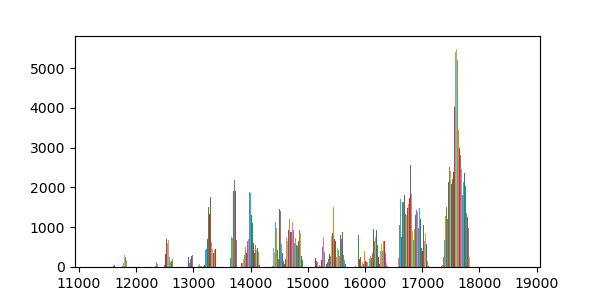

In [23]:
plt.figure(figsize=(6, 3))
plt.hist(DN_masked)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([261.53265381, 262.62966919, 263.72668457, 264.82369995,
        265.92071533, 267.01773071, 268.11474609, 269.21176147,
        270.30877686, 271.40579224, 272.50280762]),
 <a list of 7991 BarContainer objects>)

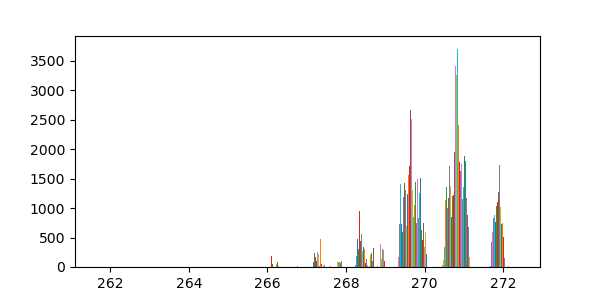

In [22]:
plt.figure(figsize=(6, 3))
plt.hist(toa)

In [32]:
for mo in ['05','11']:
    # Select appropriate atmospheric correction coefficients
    a_mo = mo
    a1 = atmcor[a_mo]['a1']
    a2 = atmcor[a_mo]['a2']
    a3 = atmcor[a_mo]['a3']
    print (f'{mo}: {a3 + a1*np.nanmean(toa) + a2*np.nanmean(wv3)*np.nanmean(toa) - 273.15}')
# Linear

05: -2.2590351534010438
11: -2.772665537320961


AttributeError: 'NoneType' object has no attribute 'plot'

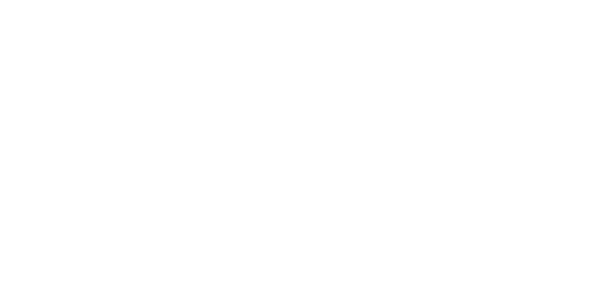

In [31]:
# Feb atm correction
plt.figure(figsize=(6, 3))
(SST).plot.imshow(x='x',y='y',vmin=-4,vmax=0)

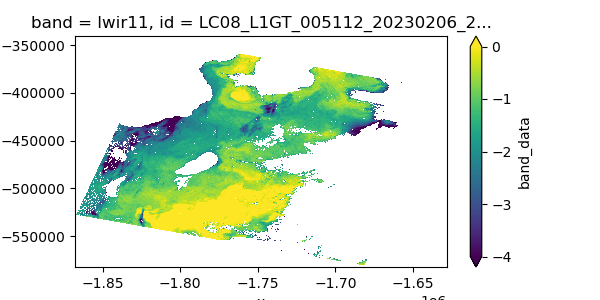

In [185]:
# January atm correction
plt.figure(figsize=(6, 3))
(SST).plot.imshow(x='x',y='y',vmin=-4,vmax=0)

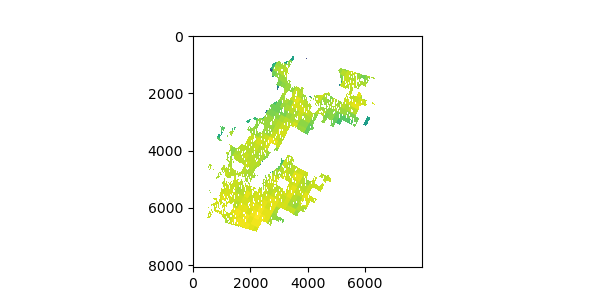

In [33]:
# no interpolation
plt.figure(figsize=(6, 3))
plt.imshow(wv0)

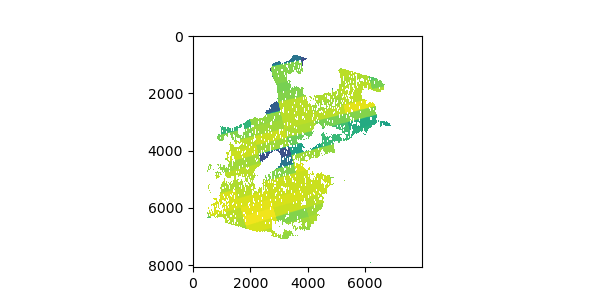

In [60]:
# no interpolation but remove 4% data
plt.figure(figsize=(6, 3))
plt.imshow(wv1)

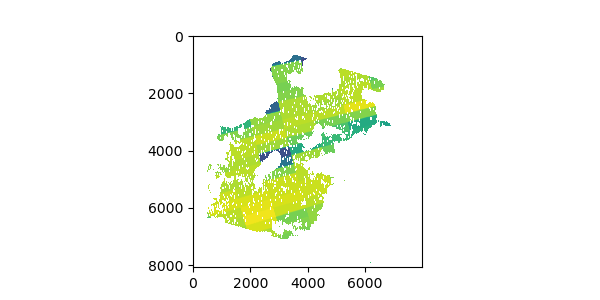

In [80]:
# Interpololation without masking
plt.figure(figsize=(6, 3))
# (ls_thermal*mask).plot.imshow(x='x',y='y')
# (SST).plot.imshow(x='x',y='y')
# (mod07.Water_Vapor).plot.pcolormesh(x='Longitude',y='Latitude')
# (ls_scene.sel(band='qa_pixel').compute()*mask).plot.imshow(x='x',y='y')
plt.imshow(wv3)

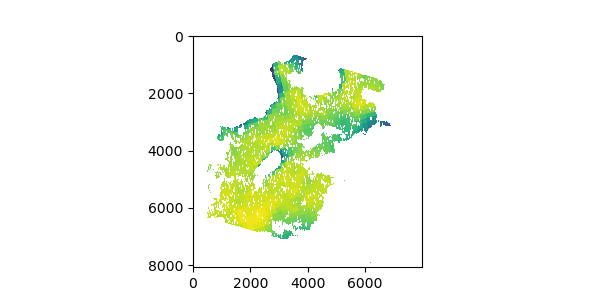

In [144]:
# Interpolation with masking
plt.figure(figsize=(6, 3))
plt.imshow(wv4)

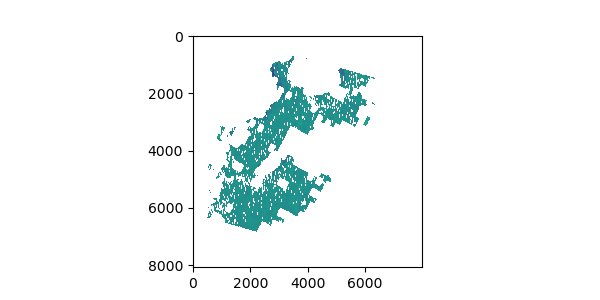

In [164]:
plt.figure(figsize=(6, 3))
plt.imshow(wv4-wv0)

In [163]:
np.unique(wv4-wv0,return_counts=True)

(array([-3.7e-04, -3.6e-04, -3.5e-04, -3.4e-04, -3.4e-04, -3.3e-04,
        -3.3e-04, -3.3e-04, -3.2e-04, -3.2e-04, -3.1e-04, -3.1e-04,
        -3.1e-04, -3.0e-04, -3.0e-04, -2.9e-04, -2.9e-04, -2.9e-04,
        -2.8e-04, -2.8e-04, -2.7e-04, -2.7e-04, -2.7e-04, -2.6e-04,
        -2.6e-04, -2.5e-04, -2.5e-04, -2.5e-04, -2.4e-04, -2.4e-04,
        -2.4e-04, -2.3e-04, -2.3e-04, -2.3e-04, -2.2e-04, -2.2e-04,
        -2.2e-04, -2.1e-04, -2.1e-04, -2.1e-04, -2.0e-04, -2.0e-04,
        -2.0e-04, -2.0e-04, -1.9e-04, -1.9e-04, -1.9e-04, -1.8e-04,
        -1.8e-04, -1.8e-04, -1.7e-04, -1.7e-04, -1.7e-04, -1.6e-04,
        -1.6e-04, -1.6e-04, -1.6e-04, -1.5e-04, -1.5e-04, -1.5e-04,
        -1.4e-04, -1.4e-04, -1.4e-04, -1.3e-04, -1.3e-04, -1.2e-04,
        -1.2e-04, -1.2e-04, -1.2e-04, -1.1e-04, -1.1e-04, -1.1e-04,
        -1.0e-04, -1.0e-04, -1.0e-04, -9.0e-05, -9.0e-05, -9.0e-05,
        -8.0e-05, -8.0e-05, -8.0e-05, -8.0e-05, -7.0e-05, -7.0e-05,
        -7.0e-05, -6.0e-05, -6.0e-05, -6.0e-05, 

In [ ]:
# Plot water vapor data ***need to comment out the delete code above for this to work
data0 = ls_thermal*mask
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(data0.x,data0.y,data0.values,vmin=14000,vmax=17800,transform=cartopy.crs.epsg(3031))
ax.coastlines()
ax.set_ylim([-78, -72])
ax.set_xlim([-111,-101])
cbar = plt.colorbar(cb)
plt.tight_layout()

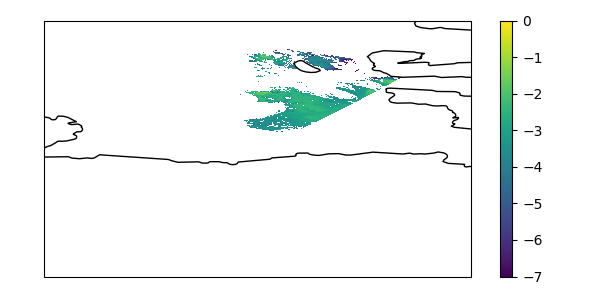

In [29]:
# Plot water vapor data ***need to comment out the delete code above for this to work
data0 = SST
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cb = ax.pcolormesh(data0.x,data0.y,data0.values,vmin=-7,vmax=0,transform=cartopy.crs.epsg(3031))
ax.coastlines()
ax.set_ylim([-78, -72])
ax.set_xlim([-111,-101])
cbar = plt.colorbar(cb)
plt.tight_layout()